# Run GalaxyGenius for Eagle Simulation

Although that GalaxyGenius is primarily designed for IllustrisTNG simulations, it can also perform galaxy generation for other simulations, with neccessary information retrieved from simulation and input to GalaxyGenius. 

Here we use [Eagle](https://icc.dur.ac.uk/Eagle/) simulation as an example.

## 1. Imports

In [1]:
import sys
sys.path.append('..')

import os
os.environ['GALAXYGENIUS_DATA_DIR'] = '/home/xczhou/nis/xczhou/mock_galaxy/galaxyGenius/Data'


from galaxyGenius.config import Configuration
from galaxyGenius.preprocess import PreProcess
from galaxyGenius.generation import DataGeneration
from galaxyGenius.postprocess import PostProcess
from galaxyGenius.utils import Units

import numpy as np
from typing import Union
from astropy.cosmology import Planck13
import astropy.units as u
import astropy.constants as const
import os
import h5py
import pandas as pd
from scipy.interpolate import interp1d

## 2. Create configurations

The configuration files are created similarly demonstrated in tutorial.

In [2]:
config = Configuration()
conf = config.get_config()

No conflicts in configurations. 👍


In [3]:
config.add_survey('CSST,HSC')
conf = config.get_config()

CSST added.
HSC added.
Minimum pivot wavelength: 0.29 micron
Maximum pivot wavelength: 0.98 micron
No conflicts in configurations. 👍


In [4]:
conf['simulation'] = 'EAGLE'
conf['snapNum'] = 27
conf['numThreads'] = 24
conf['snapRedshift'] = 0.101
conf['viewRedshift'] = 0.101
conf['includeDust'] = True
conf['dustModel'] = 'ThemisDustMix'
conf['simulationMode'] = 'ExtinctionOnly'
conf['hydrodynamicSolver'] = 'smoothParticle'
conf['numPackets'] = 1e6
conf['SEDFamily'] = 'FSPS'
conf['displaySEDxlogscale'] = False

In [5]:
config.save_config(conf)

In [6]:
conf = config.get_config()

Minimum pivot wavelength: 0.29 micron
Maximum pivot wavelength: 0.98 micron
No conflicts in configurations. 👍


## 3. Retrieve subhalo information from eagle

Subhalos can be retrieved using [eagleSqlTools](https://github.com/kyleaoman/eagleSqlTools).  Please refer to the Github for installation.

eagleSqlTools needs username and password, and can be registered [here](https://virgodb.dur.ac.uk/). 

In [7]:
import eagleSqlTools as sql

In [8]:
def build_query(keys: list, table_name: str, conditions: Union[list, None] = None, order_by: Union[str, None] = None):
    # Construct the SELECT clause with table alias
    alias = 'PROG'
    
    select_clause = ",\n    ".join([f"{alias}.{key}" for key in keys])
    query = f"SELECT\n    {select_clause}\nFROM\n    {table_name} AS {alias}"
    
    # Add WHERE conditions if provided
    if conditions:
        where_clause = " AND\n    ".join([f"{alias}.{key}" for key in conditions])
        query += f"\nWHERE\n    {where_clause}"
    
    # Add ORDER BY clause if provided
    if order_by:
        query += f"\nORDER BY\n    {alias}.{order_by}"
    
    return query

In [9]:
SubhaloKeys = [
    'GalaxyID', 'Redshift', 'MassType_Star',
    'CentreOfPotential_x', 'CentreOfPotential_y', 'CentreOfPotential_z',
    'HalfMassRad_Star', 'StarFormationRate'
]

SubhaloUnits = ['1', '1', 'Msun', 
         'cMpc', 'cMpc', 'cMpc',
         'pkpc', 'Msun/yr']

# Image_face and Image_edge are urls of galaxy images at face-on and edge-on views of EAGLE simulation.
# keys_imgs = ['Image_face', 'Image_edge']
# keys = keys + keys_imgs

table_name = "RefL0100N1504_Subhalo"
alias = "PROG"
conditions = ["Snapnum = 27", "MassType_Star > 1.0e10"]
order_by = "MassType_Star DESC"

# Generate the query
query = build_query(SubhaloKeys, table_name, conditions, order_by)
print(query)

SELECT
    PROG.GalaxyID,
    PROG.Redshift,
    PROG.MassType_Star,
    PROG.CentreOfPotential_x,
    PROG.CentreOfPotential_y,
    PROG.CentreOfPotential_z,
    PROG.HalfMassRad_Star,
    PROG.StarFormationRate
FROM
    RefL0100N1504_Subhalo AS PROG
WHERE
    PROG.Snapnum = 27 AND
    PROG.MassType_Star > 1.0e10
ORDER BY
    PROG.MassType_Star DESC


In [10]:
# specify your username and password

username = 'username'
password = 'password'

In [11]:
# query subhalo data
con = sql.connect(user=username, password=password)
data = sql.execute_query(con, query)

if os.path.exists('sql_cookies.txt'):
    os.remove('sql_cookies.txt')

In [12]:
df = pd.DataFrame(data, columns=SubhaloKeys)
df.to_csv('EAGLE_subhalos.h5', index=False)

In [11]:
df = pd.read_csv('EAGLE_subhalos.h5')

In [12]:
df.head()

,GalaxyID,Redshift,MassType_Star,CentreOfPotential_x,CentreOfPotential_y,CentreOfPotential_z,HalfMassRad_Star,StarFormationRate
0,21379522,0.100639,1.696923e+12,5.717667,75.610410,47.477654,189.744190,25.717650
1,21730536,0.100639,1.693157e+12,52.425648,4.996927,20.125082,120.196870,36.118923
2,21573587,0.100639,1.465913e+12,9.122603,35.035015,54.523600,131.478230,34.501350
3,21242351,0.100639,1.275125e+12,10.956322,81.293434,54.890770,72.678610,17.381080
4,21109761,0.100639,1.116979e+12,18.116920,79.885030,53.512390,60.974213,9.897696


## 4. Retrieve stars, starforming regions and dusts

After retrieving informations on subhalos, we can select one subhalo and obtain stars, starforming regions and dusts from the snapshot data using [pyread_eagle](https://github.com/kyleaoman/pyread_eagle).

The data cannot be retrieved using sql or requests like in IllustrisTNG. They should be downloaded from their website and saved locally. 

In [13]:
# Specify unit convention for EAGLE simulation
units = Units(cosmology=Planck13, snapRedshift=conf['snapRedshift'])
units.unit_convention()

Current unit convention is in redshift 0.101 for cosmology Planck13


In [14]:
# get subhalo informations using SubhaloID
def get_subhalo_info(SubhaloID):
    
    idx = df['GalaxyID'] == SubhaloID
    subhalo_info = df[idx]
    
    stellarMass = subhalo_info['MassType_Star'].values[0]
    halfStellarMassRadius = subhalo_info['HalfMassRad_Star'].values[0]
    
    centerPosition = np.array([subhalo_info['CentreOfPotential_x'].values[0], 
                               subhalo_info['CentreOfPotential_y'].values[0], 
                               subhalo_info['CentreOfPotential_z'].values[0]]) * units.cMpc
    
    subhaloInfo = {}
    subhaloInfo['SubhaloID'] = SubhaloID
    subhaloInfo['stellarMass'] = stellarMass * u.Msun
    subhaloInfo['halfStellarMassRadius'] = halfStellarMassRadius * units.pkpc
    
    return subhaloInfo, centerPosition

In [15]:
from pyread_eagle import EagleSnapshot

# extract particles from snapshot
def extract_particles(subhaloInfo, centerPosition, partType, params, snapdir, cosmo, conf):
    
    partRegion = (subhaloInfo['halfStellarMassRadius'] * conf['boxLengthScale']).to(u.kpc)
    partRegion = np.min([partRegion.value, conf['maxBoxLength'].to(u.kpc).value])
    partRegion = partRegion * u.kpc
    
    begin = centerPosition - partRegion / 2
    end = centerPosition + partRegion / 2
    
    
    snapfiles = [os.path.join(snapdir, name)
                 for name in os.listdir(snapdir)
                 if name.endswith('.hdf5')]
    snapfiles.sort()
    
    filename = snapfiles[0]
    f = h5py.File(filename, 'r')
    
    snap = EagleSnapshot(filename)
    
    h = cosmo.h
    a = 1 / (1 + conf['snapRedshift'])
    
    begin = (begin.to(units.cMpc / h)).value # in cMpc/h
    end = (end.to(units.cMpc / h)).value
    
    snap.select_region(begin[0], end[0],
                       begin[1], end[1],
                       begin[2], end[2])
    
    if partType in ['star', 'stars']:
        page = 'PartType4'
        pageNum = 4
    elif partType in ['gas', 'gases', 'dusts']:
        page = 'PartType0'
        pageNum = 0
    
    paramNames = list(params.keys())
    paramUnits = list(params.values())

    particles = {}
    for i, key in enumerate(paramNames):
        
        VarDescription = f[f'{page}/{key}'].attrs.get('VarDescription')
        CGSConversionFactor = f[f'{page}/{key}'].attrs.get('CGSConversionFactor')
        h_scale_exponent = f[f'{page}/{key}'].attrs.get('h-scale-exponent')
        a_scale_exponent = f[f'{page}/{key}'].attrs.get('aexp-scale-exponent')
        
        decoded_string = VarDescription.decode('utf-8')
        start_index = decoded_string.find('[') + 1
        end_index = decoded_string.find(']')
        
        if start_index > 0 and end_index > start_index:
            unit = decoded_string[start_index:end_index]
            unit = u.Unit(unit)
        elif key == 'StarFormationRate':
            unit = u.Unit('Msun/yr')
        else:
            unit = u.Unit(u.dimensionless_unscaled)
        
        info = snap.read_dataset(pageNum, key)
        info = info * a**a_scale_exponent * cosmo.h**h_scale_exponent * CGSConversionFactor * unit
        
        info = info.to(paramUnits[i])
        
        if key == 'Coordinates':
            info = info - centerPosition
            
        particles[key] = info
    
    mask = np.where((np.abs(particles['Coordinates'][:, 0]) < partRegion / 2) \
        & (np.abs(particles['Coordinates'][:, 1]) < partRegion / 2) \
        & (np.abs(particles['Coordinates'][:, 2]) < partRegion / 2))[0]
    
    for key in particles.keys():
        particles[key] = particles[key][mask]
    
    return particles

In [ ]:
# specify simulation names, snapshot directory and subhaloID
simName = 'RefL0100N1504'

eaglePath = '/share/xczhou/illustris/eagle'
snapDir = f'{eaglePath}/{simName}/snapshot_027_z000p101'

subhaloID = 20695120

In [17]:
# subhalo information and center position of the subhalo
subhaloInfo, centerPosition = get_subhalo_info(subhaloID)

In [18]:
# specify star particle parameters
starParams = ['Coordinates', 'InitialMass', 'Metallicity', 
            'SmoothingLength', 'StellarFormationTime', 'Velocity', 'Mass']
starUnits = [u.kpc, u.Msun, u.dimensionless_unscaled, 
             u.kpc, u.dimensionless_unscaled, u.km/u.s, u.Msun]
starParams = dict(zip(starParams, starUnits))

In [19]:
# extract star particles
starParts = extract_particles(
    subhaloInfo, centerPosition, 'star', starParams, snapDir, Planck13, conf
)

In [20]:
# specify gas parameters
gasParams = ['Coordinates', 'Density', 'Mass', 'Metallicity', 
            'SmoothingLength', 'StarFormationRate', 'Temperature', 'Velocity']
gasUnits= [u.kpc, u.Msun / u.kpc**3, u.Msun, 1,
           u.kpc, u.Msun / u.yr, u.K, u.km / u.s]
gasParams = dict(zip(gasParams, gasUnits))

In [21]:
# extract gas particles
gasParts = extract_particles(
    subhaloInfo, centerPosition, 'gas', gasParams, snapDir, Planck13, conf
)

## 5. Initialize `PreProcess` class

In [22]:
# initialize PreProcess class
preprocess = PreProcess(conf)

2025-10-27 16:55:17,467 - INFO - Initializing PreProcess class.
2025-10-27 16:55:17,469 - INFO - Use cosmology Planck13 at redshift 0.101


2025-10-27 16:55:17,690 - WARNING - Simulation name is unrecognized. Please manually input data by calling inputParticles() or inputs().


In [23]:
# include star and gas parameters
_ = preprocess.includeParams(starParams=starParams, gasParams=gasParams)

2025-10-27 16:55:18,427 - INFO - Coordinates,InitialMass,Metallicity,SmoothingLength,StellarFormationTime,Velocity,Mass for star particles included.
2025-10-27 16:55:18,429 - INFO - Coordinates,Density,Mass,Metallicity,SmoothingLength,StarFormationRate,Temperature,Velocity for gas particles included.


In [ ]:
# create the age interpolation
z = np.linspace(0, 4, 1000)
t = Planck13.age(z).to(u.Myr).value
fage = interp1d(z, t, kind='cubic', fill_value='extrapolate')

In [25]:
# input star and gas particles
preprocess.inputParticles('star', starParts, subhaloInfo)
preprocess.inputParticles('gas', gasParts, subhaloInfo)

2025-10-27 16:55:20,107 - INFO - ------Inputing star particles------
2025-10-27 16:55:20,129 - INFO - ------Inputing gas particles------


In [26]:
# create the working directory
workingDir = conf['workingDir']
os.makedirs(workingDir, exist_ok=True)

In [28]:
# Create star function
def starFunction(particles):
    
    starFormationMask = np.where(particles['StellarFormationTime'] > 0)[0]
    snapshotAge = fage(conf['snapRedshift']) * u.Myr
    particles['age'] = snapshotAge - fage(1/particles['StellarFormationTime'] - 1) * u.Myr
    ageMask = np.where(particles['age'] > conf['ageThreshold'])[0]
    
    idx = np.intersect1d(starFormationMask, ageMask)
    
    print(f'Stars: {len(idx)}')
    
    properties = {}
    properties['x-coordinate'] = particles['Coordinates'][:, 0][idx]
    properties['y-coordinate'] = particles['Coordinates'][:, 1][idx]
    properties['z-coordinate'] = particles['Coordinates'][:, 2][idx]
    properties['smoothing length'] = particles['SmoothingLength'][idx]
    properties['initial mass'] = particles['InitialMass'][idx]
    properties['metallicity'] = particles['Metallicity'][idx]
    properties['age'] = particles['age'][idx]
    properties['x-velocity'] = particles['Velocity'][:, 0][idx]
    properties['y-velocity'] = particles['Velocity'][:, 1][idx]
    properties['z-velocity'] = particles['Velocity'][:, 2][idx]
    properties['mass'] = particles['Mass'][idx]
    
    return properties

In [29]:
# create star particle file
paramNames = ['x-coordinate', 'y-coordinate', 'z-coordinate', 'smoothing length',
            'initial mass', 'metallicity', 'age', 'x-velocity', 'y-velocity', 'z-velocity', 'mass']

preprocess.createFile(paramNames, 'star', os.path.join(workingDir, 'stars.txt'), starFunction)

Stars: 163839


In [30]:
def starFormingFunction(particles):
    
    starFormationMask = np.where(particles['StellarFormationTime'] > 0)[0]
    snapshotAge = fage(conf['snapRedshift']) * u.Myr
    particles['age'] = snapshotAge - fage(1/particles['StellarFormationTime'] - 1) * u.Myr
    ageMask = np.where(particles['age'] < conf['ageThreshold'])[0]
    
    idx = np.intersect1d(starFormationMask, ageMask)
    print(f'Star forming region: {len(idx)}')
    
    properties = {}
    properties['x-coordinate'] = particles['Coordinates'][:, 0][idx]
    properties['y-coordinate'] = particles['Coordinates'][:, 1][idx]
    properties['z-coordinate'] = particles['Coordinates'][:, 2][idx]
    properties['smoothing length'] = particles['SmoothingLength'][idx]
    properties['star formation rate'] = (particles['InitialMass'][idx] / conf['ageThreshold']).to(u.Msun / u.yr)
    properties['metallicity'] = particles['Metallicity'][idx]
    # from Kapoor et al. 2021
    properties['compactness'] = np.random.normal(loc=conf['logCompactnessMean'], 
                                                scale=conf['logCompactnessStd'], size=idx.shape[0]) * u.dimensionless_unscaled
    
    pressure = (10**conf['logPressure'] * const.k_B * u.K * u.cm**-3).to(u.J / u.m**3) # J / m**3 == Pa
    properties['pressure'] = np.full(idx.shape[0], pressure.value) * pressure.unit
    if conf['constantCoveringFactor']:
        properties['covering factor'] = np.full(idx.shape[0], conf['coveringFactor']) * u.dimensionless_unscaled
    else:
        # from Baes, M., et al. 2024
        properties['covering factor'] = np.exp(-particles['age'][idx] / conf['PDRClearingTimescale']) * u.dimensionless_unscaled
    
    properties['x-velocity'] = particles['Velocity'][:, 0][idx] # in km/s
    properties['y-velocity'] = particles['Velocity'][:, 1][idx] # in km/s
    properties['z-velocity'] = particles['Velocity'][:, 2][idx] # in km/s
    properties['mass'] = particles['Mass'][idx] # in Msun
    
    return properties

In [31]:
paramNames = ['x-coordinate', 'y-coordinate', 'z-coordinate', 'smoothing length',
            'star formation rate', 'metallicity', 'compactness', 'pressure', 'covering factor',
            'x-velocity', 'y-velocity', 'z-velocity', 'mass']

preprocess.createFile(paramNames, 'starforming', 
                    os.path.join(workingDir, 'starforming_regions.txt'), 
                    starFormingFunction)

Star forming region: 52


In [32]:
def dustFunction(particles):
    
    if conf['DISMModel'] == 'Camps_2016':
        temperatureThreshold = conf['temperatureThreshold']
        idx = np.where((particles['StarFormationRate'] > 0) \
            | (particles['Temperature'] < temperatureThreshold))[0]
    elif conf['DISMModel'] == 'Torrey_2012':
        left = np.log10(particles['Temperature'].to(u.K).value)
        right_log = np.log10(particles['Density'].to(10**10 * self.h**2 * u.Msun * u.kpc**-3).value)
        right = 6 + 0.25 * right_log
        idx = np.where(left < right)[0]
    
    print(f'Dust: {len(idx)}')
    
    properties = {}
    properties['x-coordinate'] = particles['Coordinates'][:, 0][idx]
    properties['y-coordinate'] = particles['Coordinates'][:, 1][idx]
    properties['z-coordinate'] = particles['Coordinates'][:, 2][idx]
    properties['smoothing length'] = particles['SmoothingLength'][idx]
    properties['mass'] = particles['Mass'][idx]
    properties['metallicity'] = particles['Metallicity'][idx]
    properties['temperature'] = particles['Temperature'][idx]
    properties['x-velocity'] = particles['Velocity'][:, 0][idx]
    properties['y-velocity'] = particles['Velocity'][:, 1][idx]
    properties['z-velocity'] = particles['Velocity'][:, 2][idx]
    
    return properties

In [33]:
paramNames = ['x-coordinate', 'y-coordinate', 'z-coordinate', 'smoothing length', 'mass',
            'metallicity', 'temperature', 'x-velocity', 'y-velocity', 'z-velocity']

preprocess.createFile(paramNames, 'dust', 
                        os.path.join(workingDir, 'dusts.txt'), 
                        dustFunction)

Dust: 8026


In [34]:
# prepare .ski file
preprocess.prepare()

2025-10-27 16:56:05,287 - INFO - Use cosmology Planck13 at redshift 0.101
2025-10-27 16:56:05,462 - WARNING - Simulation name is unrecognized. Please manually input data by calling inputParticles() or inputs().
2025-10-27 16:56:05,464 - INFO - Creating .ski file.
2025-10-27 16:56:05,468 - INFO - ------Calculating face-on and edge-on viewing angles------
2025-10-27 16:56:05,954 - INFO - Face-on angle (inc, azi): 77.32 deg, 68.70 deg
2025-10-27 16:56:05,955 - INFO - Edge-on angle (inc, azi): 166.43 deg, 90.00 deg
2025-10-27 16:56:05,956 - INFO - Using calculated face-on and edge-on angles
2025-10-27 16:56:05,957 - INFO - View 0: Inclination = 77.32 deg, Azimuth = 68.70 deg
2025-10-27 16:56:05,957 - INFO - View 1: Inclination = 166.43 deg, Azimuth = 90.00 deg
2025-10-27 16:56:05,991 - INFO - ------estimate memory usage------
2025-10-27 16:56:05,992 - INFO - numViews: 2
2025-10-27 16:56:05,993 - INFO - numSpatialPixels: 1741
2025-10-27 16:56:05,993 - INFO - numWavelengthPixels: 300
2025-10

`properties.json` and `skirt.ski` are created in working directory

## 6. Run SKIRT

In [35]:
dataGeneration = DataGeneration(config=conf)
dataGeneration.runSKIRT()

2025-10-27 16:56:45,927 - INFO - Initializing DataGeneration class.
2025-10-27 16:56:45,932 - INFO - Running SKIRT
2025-10-27 16:56:45,933 - INFO - Subhalo ID: 20695120
27/10/2025 16:56:45.942   Welcome to SKIRT v9.0 (git 382ad4b built on 15/08/2024 at 01:46:45)
27/10/2025 16:56:45.942   Running on 2488h for xczhou
27/10/2025 16:56:45.942   Constructing a simulation from ski file 'skirt.ski'...
27/10/2025 16:56:45.979   Starting simulation skirt using 24 threads and a single process...
27/10/2025 16:56:45.980   Starting setup...
27/10/2025 16:56:45.980     Panchromatic wavelength regime
27/10/2025 16:56:45.980     With transfer medium
27/10/2025 16:56:45.980     Redshift: 0.101
27/10/2025 16:56:45.980     Luminosity distance: 480.464 Mpc
27/10/2025 16:56:45.980     Model and grid symmetry: 3D
27/10/2025 16:56:45.980     Photon life cycle: no explicit absorption; with forced scattering
27/10/2025 16:56:45.980   FSPSSEDFamily opened stored table /share/xczhou/SKIRT/resources/SKIRT9_Resou

0

## 7. Mock Observation

2025-10-27 16:57:54,649 - INFO - Initializing PostProcess class.
2025-10-27 16:57:54,679 - INFO - Run Postprocessing
2025-10-27 16:57:54,680 - INFO - Begin postprocessing for CSST
2025-10-27 16:57:54,731 - INFO - Generating images for view 0.
2025-10-27 16:58:10,556 - INFO - Processing CSST NUV.
2025-10-27 16:58:11,388 - INFO - Processing CSST u.
2025-10-27 16:58:12,351 - INFO - Processing CSST g.
2025-10-27 16:58:14,083 - INFO - Processing CSST r.
2025-10-27 16:58:15,767 - INFO - Processing CSST i.
2025-10-27 16:58:17,563 - INFO - Processing CSST z.
2025-10-27 16:58:19,860 - INFO - Processing CSST y.
2025-10-27 16:58:34,791 - INFO - Generating images for view 1.
2025-10-27 16:58:45,456 - INFO - Processing CSST NUV.
2025-10-27 16:58:45,931 - INFO - Processing CSST u.
2025-10-27 16:58:46,466 - INFO - Processing CSST g.
2025-10-27 16:58:47,802 - INFO - Processing CSST r.
2025-10-27 16:58:48,986 - INFO - Processing CSST i.
2025-10-27 16:58:49,990 - INFO - Processing CSST z.
2025-10-27 16:

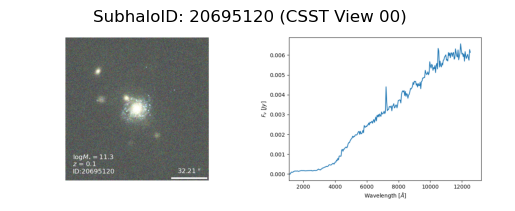

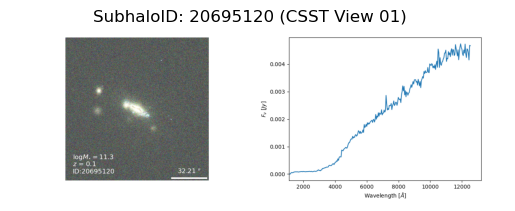

2025-10-27 16:59:04,281 - INFO - Finish postprocessing for CSST
2025-10-27 16:59:04,282 - INFO - Time taken to postprocess for CSST: 69.60 seconds
2025-10-27 16:59:04,283 - INFO - Begin postprocessing for HSC
2025-10-27 16:59:04,319 - INFO - Generating images for view 0.
2025-10-27 16:59:09,773 - INFO - Processing HSC g.
2025-10-27 16:59:11,110 - INFO - Processing HSC r.
2025-10-27 16:59:13,051 - INFO - Processing HSC i.
2025-10-27 16:59:14,528 - INFO - Processing HSC z.
2025-10-27 16:59:15,370 - INFO - Processing HSC y.
2025-10-27 16:59:18,478 - INFO - Generating images for view 1.
2025-10-27 16:59:24,506 - INFO - Processing HSC g.
2025-10-27 16:59:25,853 - INFO - Processing HSC r.
2025-10-27 16:59:27,177 - INFO - Processing HSC i.
2025-10-27 16:59:28,627 - INFO - Processing HSC z.
2025-10-27 16:59:29,473 - INFO - Processing HSC y.
2025-10-27 16:59:32,199 - INFO - Saving bandpass images.
2025-10-27 16:59:32,553 - INFO - Saving SEDs


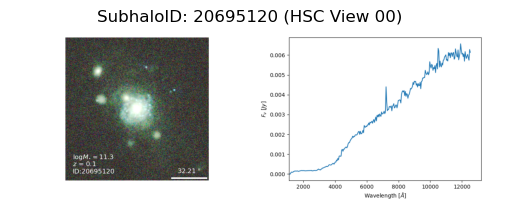

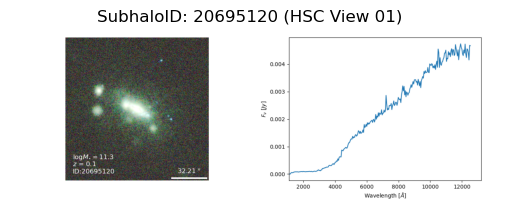

2025-10-27 16:59:33,419 - INFO - Finish postprocessing for HSC
2025-10-27 16:59:33,420 - INFO - Time taken to postprocess for HSC: 29.14 seconds


In [36]:
postprocess = PostProcess(subhaloID=subhaloID)
postprocess.runPostprocess(showImages=True)